In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

    
from tokenizers import Tokenizer, models



# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# =====================
# 参数配置
# =====================
import torch

PARAMS = {
    "MODEL_TYPE": "decoder-only",   # "encoder-decoder" 或 "decoder-only"
    "EMBED_DIM": 128,
    "HIDDEN_DIM": 256,
    "NUM_LAYERS": 2,
    "NUM_HEADS": 4,
    "DROPOUT": 0.1,
    "LR": 1e-3,
    "BATCH_SIZE": 64,
    "EPOCHS": 5,
    "MAX_SEQ_LEN": 64,
    "TOKENIZER_TYPE": "bpe"  # 可选"char","bpe"或”word“ "pretrained-bpe" 

}

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 日志保存文件
RESULTS_FILE = "/kaggle/working/results.csv"

In [3]:
# =====================
# 数据加载 & 预处理
# =====================
import os
from torch.utils.data import Dataset, DataLoader

# Tokenizer 类型: "word" / "char" / "bpe" / "pretrained-bpe"
TOKENIZER_TYPE = PARAMS["TOKENIZER_TYPE"]

DATA_DIR = "wiki"  
TRAIN_FILE = os.path.join(DATA_DIR, "wiki.train.tokens")
VALID_FILE = os.path.join(DATA_DIR, "wiki.valid.tokens")
TEST_FILE  = os.path.join(DATA_DIR, "wiki.test.tokens")

def load_file(path):
    with open(path, encoding="utf-8") as f:
        return [line.strip() for line in f if line.strip()]

train_texts = load_file(TRAIN_FILE)
valid_texts = load_file(VALID_FILE)
test_texts  = load_file(TEST_FILE)

# ========= BPE工具函数 =========
def encode_dataset(texts, tokenizer, max_len):
    data = []
    pad_id = tokenizer.token_to_id("<pad>")
    for text in texts:
        ids = tokenizer.encode(text).ids
        ids = ids[:max_len+1]   # 保留 max_len+1，训练时切分成输入和目标
        if len(ids) < max_len+1:
            ids += [pad_id] * (max_len+1 - len(ids))
        data.append(ids)
    return data

# ========= Tokenizer 定义 =========
if TOKENIZER_TYPE == "word":
    def tokenize(texts):
        return [line.split() for line in texts]
    train_tokens = tokenize(train_texts)
    valid_tokens = tokenize(valid_texts)
    test_tokens  = tokenize(test_texts)

    vocab = {"<pad>":0, "<unk>":1}
    for line in train_tokens:
        for tok in line:
            if tok not in vocab:
                vocab[tok] = len(vocab)

elif TOKENIZER_TYPE == "char":
    def tokenize(texts):
        return [list(line) for line in texts]
    train_tokens = tokenize(train_texts)
    valid_tokens = tokenize(valid_texts)
    test_tokens  = tokenize(test_texts)

    vocab = {"<pad>":0, "<unk>":1}
    for line in train_tokens:
        for tok in line:
            if tok not in vocab:
                vocab[tok] = len(vocab)

elif TOKENIZER_TYPE == "bpe":
    # 用 train 的数据训练一个 BPE 分词器
    from tokenizers import Tokenizer, models, trainers, pre_tokenizers
    tok = Tokenizer(models.BPE())
    tok.pre_tokenizer = pre_tokenizers.Whitespace()
    trainer = trainers.BpeTrainer(special_tokens=["<pad>", "<unk>"])
    tok.train_from_iterator(train_texts, trainer)

    train_tokens = encode_dataset(train_texts, tok, PARAMS["MAX_SEQ_LEN"])
    valid_tokens = encode_dataset(valid_texts, tok, PARAMS["MAX_SEQ_LEN"])
    test_tokens  = encode_dataset(test_texts,  tok, PARAMS["MAX_SEQ_LEN"])

    vocab = tok.get_vocab()
    if "<pad>" not in vocab:
        vocab["<pad>"] = len(vocab)
    if "<unk>" not in vocab:
        vocab["<unk>"] = len(vocab)

elif TOKENIZER_TYPE == "pretrained-bpe":
    from tokenizers import Tokenizer, models
    tokenizer = Tokenizer(models.BPE.from_file(
        vocab="tokenizer/vocab.json",
        merges="tokenizer/merges.txt"
    ))

    # ---- 强制补充 <pad> 和 <unk> ----
    vocab = tokenizer.get_vocab()
    if "<pad>" not in vocab:
        pad_id = len(vocab)
        vocab["<pad>"] = pad_id
    else:
        pad_id = vocab["<pad>"]

    if "<unk>" not in vocab:
        unk_id = len(vocab)
        vocab["<unk>"] = unk_id
    else:
        unk_id = vocab["<unk>"]

    def encode_dataset(texts, tokenizer, max_len):
        data = []
        for text in texts:
            ids = tokenizer.encode(text).ids
            ids = ids[:max_len+1]
            if len(ids) < max_len+1:
                ids += [pad_id] * (max_len+1 - len(ids))  # 🔥 这里 pad_id 一定是整数
            data.append(ids)
        return data

    train_tokens = encode_dataset(train_texts, tokenizer, PARAMS["MAX_SEQ_LEN"])
    valid_tokens = encode_dataset(valid_texts, tokenizer, PARAMS["MAX_SEQ_LEN"])
    test_tokens  = encode_dataset(test_texts,  tokenizer, PARAMS["MAX_SEQ_LEN"])

    VOCAB_SIZE = len(vocab)
    PAD_IDX = vocab["<pad>"]
    UNK_IDX = vocab["<unk>"]


else:
    raise ValueError("TOKENIZER_TYPE must be 'word', 'char', 'bpe', or 'pretrained-bpe'")

PAD_IDX = vocab["<pad>"]
UNK_IDX = vocab["<unk>"]
VOCAB_SIZE = len(vocab)

# ========== 编码函数 ==========
def encode(tokens, vocab, max_len):
    """word/char 模式"""
    ids = [vocab.get(t, UNK_IDX) for t in tokens]
    ids = ids[:max_len]
    ids += [PAD_IDX] * (max_len - len(ids))
    return ids

# ========== Dataset ==========
class TextDataset(Dataset):
    def __init__(self, data, vocab, max_len, mode="word"):
        self.data = data
        self.vocab = vocab
        self.max_len = max_len
        self.mode = mode

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if self.mode in ["word", "char"]:
            tokens = self.data[idx]
            x = encode(tokens[:-1], self.vocab, self.max_len)
            y = encode(tokens[1:], self.vocab, self.max_len)
        else:  # bpe / pretrained-bpe
            ids = self.data[idx]
    
            # --- 调试: 打印有问题的数据 ---
            if ids is None:
                print(f"[ERROR] idx {idx} got None in self.data")
            elif any(t is None for t in ids):
                print(f"[ERROR] idx {idx} contains None inside ids: {ids}")
    
            x = ids[:-1]
            y = ids[1:]
            if len(x) < self.max_len:
                x += [PAD_IDX] * (self.max_len - len(x))
            if len(y) < self.max_len:
                y += [PAD_IDX] * (self.max_len - len(y))
            x = x[:self.max_len]
            y = y[:self.max_len]
    
        return torch.tensor(x, dtype=torch.long), torch.tensor(y, dtype=torch.long)



train_dataset = TextDataset(train_tokens, vocab, PARAMS["MAX_SEQ_LEN"], TOKENIZER_TYPE)
valid_dataset = TextDataset(valid_tokens, vocab, PARAMS["MAX_SEQ_LEN"], TOKENIZER_TYPE)
test_dataset  = TextDataset(test_tokens, vocab, PARAMS["MAX_SEQ_LEN"], TOKENIZER_TYPE)

train_loader = DataLoader(train_dataset, batch_size=PARAMS["BATCH_SIZE"], shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=PARAMS["BATCH_SIZE"])
test_loader  = DataLoader(test_dataset,  batch_size=PARAMS["BATCH_SIZE"])


In [4]:
import os, json, time
import matplotlib.pyplot as plt

def create_experiment_dir(params):
    """创建实验目录并保存参数"""
    timestamp = time.strftime("%Y%m%d-%H%M%S")
    exp_name = f"{params['MODEL_TYPE']}_lr{params['LR']}_drop{params['DROPOUT']}_layers{params['NUM_LAYERS']}_{timestamp}"
    exp_dir = os.path.join("results", exp_name)
    os.makedirs(exp_dir, exist_ok=True)

    # 保存参数配置
    with open(os.path.join(exp_dir, "params.json"), "w") as f:
        json.dump(params, f, indent=4)

    return exp_dir


In [5]:
# =====================
# 模型定义
# =====================
import torch.nn as nn

class TransformerModel(nn.Module):
    def __init__(self, model_type, vocab_size, embed_dim, hidden_dim, num_layers, num_heads, dropout, max_len):
        super().__init__()
        self.model_type = model_type
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=PAD_IDX)
        self.pos_encoding = nn.Embedding(max_len, embed_dim)

        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dim_feedforward=hidden_dim, dropout=dropout)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        decoder_layer = nn.TransformerDecoderLayer(d_model=embed_dim, nhead=num_heads, dim_feedforward=hidden_dim, dropout=dropout)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)

        self.fc = nn.Linear(embed_dim, vocab_size)

    def forward(self, src, tgt=None):
        seq_len = src.size(1)
        pos = torch.arange(0, seq_len, device=src.device).unsqueeze(0)
        src_embed = self.embedding(src) + self.pos_encoding(pos)

        if self.model_type == "encoder-decoder":
            memory = self.encoder(src_embed.transpose(0,1))  # (S,N,E)
            if tgt is not None:
                tgt_seq_len = tgt.size(1)
                tgt_pos = torch.arange(0, tgt_seq_len, device=tgt.device).unsqueeze(0)
                tgt_embed = self.embedding(tgt) + self.pos_encoding(tgt_pos)
                output = self.decoder(tgt_embed.transpose(0,1), memory)
            else:
                output = memory
        else:  # decoder-only
            output = self.encoder(src_embed.transpose(0,1))

        logits = self.fc(output.transpose(0,1))
        return logits


In [6]:
# =====================
# 训练 & 验证 & 测试
# =====================
import torch.optim as optim
from torch.nn.functional import cross_entropy

# def train_model(model, train_loader, valid_loader, test_loader, params):
#     optimizer = optim.Adam(model.parameters(), lr=params["LR"])
#     best_valid_loss = float("inf")

#     results = {"train_loss": [], "train_acc": [], "valid_loss": [], "valid_acc": []}

#     for epoch in range(params["EPOCHS"]):
#         # ---------- Train ----------
#         model.train()
#         total_loss, total_correct, total_count = 0, 0, 0
#         for x, y in train_loader:
#             x, y = x.to(DEVICE), y.to(DEVICE)
#             optimizer.zero_grad()
#             output = model(x, x if params["MODEL_TYPE"]=="encoder-decoder" else None)
#             loss = cross_entropy(output.view(-1, VOCAB_SIZE), y.view(-1), ignore_index=PAD_IDX)
#             loss.backward()
#             optimizer.step()
#             total_loss += loss.item()
#             total_correct += (output.argmax(-1) == y).sum().item()
#             total_count += y.numel()
#         train_loss = total_loss / len(train_loader)
#         train_acc  = total_correct / total_count

#         # ---------- Valid ----------
#         model.eval()
#         total_loss, total_correct, total_count = 0, 0, 0
#         with torch.no_grad():
#             for x, y in valid_loader:
#                 x, y = x.to(DEVICE), y.to(DEVICE)
#                 output = model(x, x if params["MODEL_TYPE"]=="encoder-decoder" else None)
#                 loss = cross_entropy(output.view(-1, VOCAB_SIZE), y.view(-1), ignore_index=PAD_IDX)
#                 total_loss += loss.item()
#                 total_correct += (output.argmax(-1) == y).sum().item()
#                 total_count += y.numel()
#         valid_loss = total_loss / len(valid_loader)
#         valid_acc  = total_correct / total_count

#         print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Acc={train_acc:.4f}, Valid Loss={valid_loss:.4f}, Acc={valid_acc:.4f}")

#         results["train_loss"].append(train_loss)
#         results["train_acc"].append(train_acc)
#         results["valid_loss"].append(valid_loss)
#         results["valid_acc"].append(valid_acc)

#     # ---------- Test ----------
#     model.eval()
#     total_loss, total_correct, total_count = 0, 0, 0
#     with torch.no_grad():
#         for x, y in test_loader:
#             x, y = x.to(DEVICE), y.to(DEVICE)
#             output = model(x, x if params["MODEL_TYPE"]=="encoder-decoder" else None)
#             loss = cross_entropy(output.view(-1, VOCAB_SIZE), y.view(-1), ignore_index=PAD_IDX)
#             total_loss += loss.item()
#             total_correct += (output.argmax(-1) == y).sum().item()
#             total_count += y.numel()
#     test_loss = total_loss / len(test_loader)
#     test_acc  = total_correct / total_count

#     print(f"Test: Loss={test_loss:.4f}, Acc={test_acc:.4f}")
#     return results, (test_loss, test_acc)

def train_model(model, train_loader, valid_loader, test_loader, params):
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=params["LR"])

    # === 新增：创建实验目录 ===
    exp_dir = create_experiment_dir(params)
    log_file = open(os.path.join(exp_dir, "train_log.txt"), "w")

    results = {"train_loss": [], "train_acc": [], "valid_loss": [], "valid_acc": []}

    for epoch in range(1, params["EPOCHS"]+1):
        # ---------- Train ----------
        model.train()
        total_loss, total_correct, total_count = 0, 0, 0
        for x, y in train_loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            optimizer.zero_grad()
            output = model(x, x if params["MODEL_TYPE"]=="encoder-decoder" else None)
            loss = cross_entropy(output.view(-1, VOCAB_SIZE), y.view(-1), ignore_index=PAD_IDX)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            total_correct += (output.argmax(-1) == y).sum().item()
            total_count += y.numel()

        train_loss = total_loss / len(train_loader)
        train_acc = total_correct / total_count
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)

        # ---------- Valid ----------
        model.eval()
        total_loss, total_correct, total_count = 0, 0, 0
        with torch.no_grad():
            for x, y in valid_loader:
                x, y = x.to(DEVICE), y.to(DEVICE)
                output = model(x, x if params["MODEL_TYPE"]=="encoder-decoder" else None)
                loss = cross_entropy(output.view(-1, VOCAB_SIZE), y.view(-1), ignore_index=PAD_IDX)
                total_loss += loss.item()
                total_correct += (output.argmax(-1) == y).sum().item()
                total_count += y.numel()

        valid_loss = total_loss / len(valid_loader)
        valid_acc = total_correct / total_count
        results["valid_loss"].append(valid_loss)
        results["valid_acc"].append(valid_acc)

        log_str = f"Epoch {epoch}: Train Loss={train_loss:.4f}, Acc={train_acc:.4f}, Valid Loss={valid_loss:.4f}, Acc={valid_acc:.4f}"
        print(log_str)
        log_file.write(log_str + "\n")

    # ---------- Test ----------
    total_loss, total_correct, total_count = 0, 0, 0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            output = model(x, x if params["MODEL_TYPE"]=="encoder-decoder" else None)
            loss = cross_entropy(output.view(-1, VOCAB_SIZE), y.view(-1), ignore_index=PAD_IDX)
            total_loss += loss.item()
            total_correct += (output.argmax(-1) == y).sum().item()
            total_count += y.numel()

    test_loss = total_loss / len(test_loader)
    test_acc  = total_correct / total_count
    test_result = {"test_loss": test_loss, "test_acc": test_acc}

    test_str = f"Test: Loss={test_loss:.4f}, Acc={test_acc:.4f}"
    print(test_str)
    log_file.write(test_str + "\n")
    log_file.close()

    # === 保存 results.json ===
    import json
    with open(os.path.join(exp_dir, "results.json"), "w") as f:
        json.dump({"train_valid": results, "test": test_result}, f, indent=4)

    # === 保存曲线图 ===
    plt.figure()
    plt.plot(results["train_loss"], label="Train Loss")
    plt.plot(results["valid_loss"], label="Valid Loss")
    plt.legend()
    plt.title("Loss Curve")
    plt.savefig(os.path.join(exp_dir, "loss_curve.png"))

    plt.figure()
    plt.plot(results["train_acc"], label="Train Acc")
    plt.plot(results["valid_acc"], label="Valid Acc")
    plt.legend()
    plt.title("Accuracy Curve")
    plt.savefig(os.path.join(exp_dir, "acc_curve.png"))

    print(f"✅ 实验结果已保存到 {exp_dir}")

    return results, test_result



In [7]:
import matplotlib.pyplot as plt

def plot_results(results):
    epochs = range(1, len(results["train_loss"]) + 1)

    # Loss
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(epochs, results["train_loss"], label="Train Loss")
    plt.plot(epochs, results["valid_loss"], label="Valid Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss over Epochs")
    plt.legend()

    # Accuracy
    plt.subplot(1,2,2)
    plt.plot(epochs, results["train_acc"], label="Train Acc")
    plt.plot(epochs, results["valid_acc"], label="Valid Acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy over Epochs")
    plt.legend()

    plt.tight_layout()
    plt.show()




/root/miniconda3/lib/python3.10/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 1: Train Loss=5.2093, Acc=0.2389, Valid Loss=1.9078, Acc=0.5022
Epoch 2: Train Loss=1.2191, Acc=0.5526, Valid Loss=0.4777, Acc=0.6210
Epoch 3: Train Loss=0.3716, Acc=0.6202, Valid Loss=0.1982, Acc=0.6461
Epoch 4: Train Loss=0.1676, Acc=0.6359, Valid Loss=0.1327, Acc=0.6499
Epoch 5: Train Loss=0.1143, Acc=0.6386, Valid Loss=0.1161, Acc=0.6515
Test: Loss=0.1156, Acc=0.6281
✅ 实验结果已保存到 results/decoder-only_lr0.001_drop0.1_layers2_20250928-163553


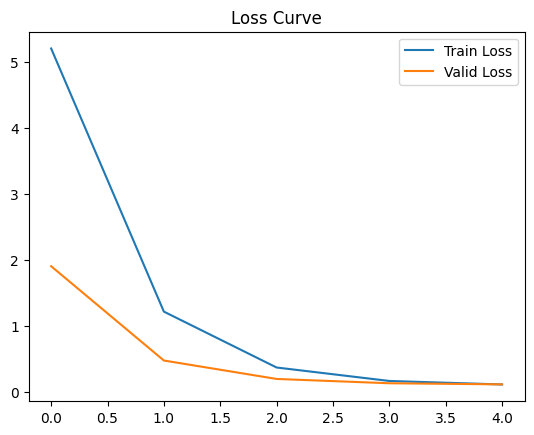

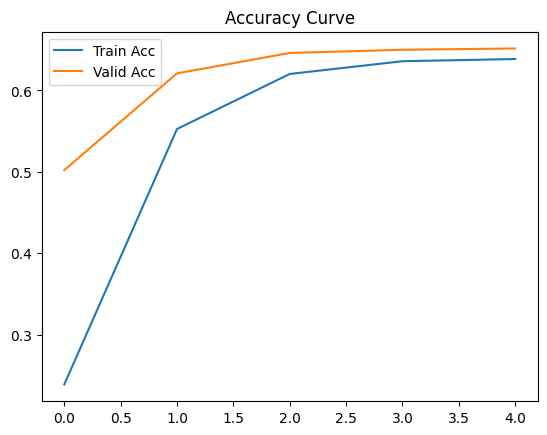

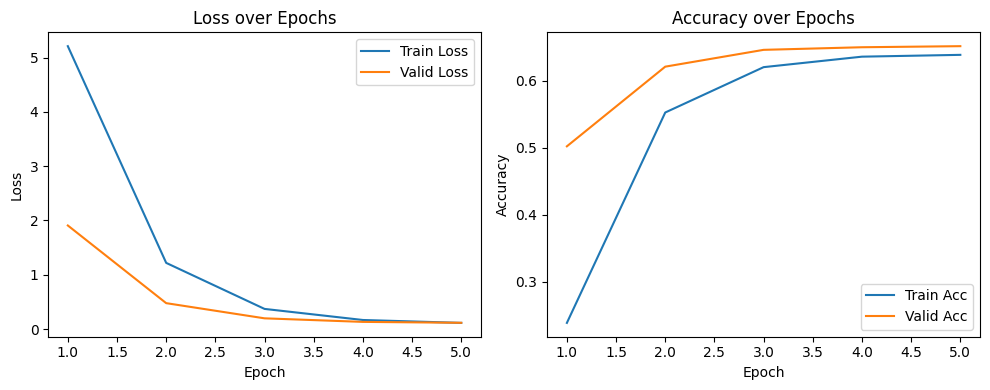

In [8]:
# =====================
# 主程序
# =====================
model = TransformerModel(
    model_type=PARAMS["MODEL_TYPE"],
    vocab_size=VOCAB_SIZE,
    embed_dim=PARAMS["EMBED_DIM"],
    hidden_dim=PARAMS["HIDDEN_DIM"],
    num_layers=PARAMS["NUM_LAYERS"],
    num_heads=PARAMS["NUM_HEADS"],
    dropout=PARAMS["DROPOUT"],
    max_len=PARAMS["MAX_SEQ_LEN"]
).to(DEVICE)

results, test_result = train_model(model, train_loader, valid_loader, test_loader, PARAMS)
plot_results(results)


In [9]:
def count_unk(data, unk_idx):
    total, unk_count = 0, 0
    for ids in data:
        total += len(ids)
        unk_count += sum(1 for t in ids if t == unk_idx)
    return unk_count, total, unk_count / total

if TOKENIZER_TYPE in ["bpe", "pretrained-bpe"]:
    train_unk, train_total, train_ratio = count_unk(train_tokens, UNK_IDX)
    valid_unk, valid_total, valid_ratio = count_unk(valid_tokens, UNK_IDX)
    test_unk,  test_total,  test_ratio  = count_unk(test_tokens,  UNK_IDX)

    print(f"[UNK] stats:")
    print(f"  Train: {train_unk}/{train_total} ({train_ratio:.2%})")
    print(f"  Valid: {valid_unk}/{valid_total} ({valid_ratio:.2%})")
    print(f"  Test : {test_unk}/{test_total} ({test_ratio:.2%})")


[UNK] stats:
  Train: 26353/1544855 (1.71%)
  Valid: 5991/159965 (3.75%)
  Test : 8021/187915 (4.27%)


In [10]:
# 打印前 10 条训练文本
for i, line in enumerate(train_texts[:10]):
    print(f"{i}: {line}")


0: = Valkyria Chronicles III =
1: Senjō no Valkyria 3 : <unk> Chronicles ( Japanese : 戦場のヴァルキュリア3 , lit . Valkyria of the Battlefield 3 ) , commonly referred to as Valkyria Chronicles III outside Japan , is a tactical role @-@ playing video game developed by Sega and Media.Vision for the PlayStation Portable . Released in January 2011 in Japan , it is the third game in the Valkyria series . <unk> the same fusion of tactical and real @-@ time gameplay as its predecessors , the story runs parallel to the first game and follows the " Nameless " , a penal military unit serving the nation of Gallia during the Second Europan War who perform secret black operations and are pitted against the Imperial unit " <unk> Raven " .
2: The game began development in 2010 , carrying over a large portion of the work done on Valkyria Chronicles II . While it retained the standard features of the series , it also underwent multiple adjustments , such as making the game more <unk> for series newcomers . Char

In [11]:
lengths = [len(line.split()) for line in train_texts]  # 按词数计算长度
print(f"训练集文本总数: {len(train_texts)}")
print(f"平均长度: {sum(lengths)/len(lengths):.2f} 词")
print(f"最长文本: {max(lengths)} 词, 最短文本: {min(lengths)} 词")


训练集文本总数: 23767
平均长度: 86.33 词
最长文本: 699 词, 最短文本: 1 词
